In [2]:
import boto3
import io
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#import awswrangler as wr
#import s3fs
#from fastparquet import write

import joblib

#modeling
import statsmodels.api as sm
from statsmodels.api import add_constant
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,ShuffleSplit, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, f1_score, precision_recall_curve
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, brier_score_loss
from sklearn.utils import resample


import lightgbm as lgbm

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

### Data Load

In [3]:
df =  pd.read_parquet('model_ready.parquet')

In [4]:
df.shape

(4375253, 246)

In [5]:
#### out-date
out_date = '2022-06'

In [ ]:
### additional features

In [6]:
df['policy_age_diff_aum']=df['policy_age']/12*df['diff_aum_cash_val']

In [7]:
df['policy_age_cash1']=df['policy_age']/12*df['mod_mpt_total']
df['policy_age_cash2']=df['policy_age']/12*df['mpt_total_bld_face_amt']

In [8]:
df['holder_age_cash1']=df['holder_age']*df['mod_mpt_total']
df['holder_age_cash2']=df['holder_age']*df['mpt_total_bld_face_amt']

In [9]:
df['issue_age_cash1']=df['issue_age']*df['mod_mpt_total']
df['issue_age_cash2']=df['issue_age']*df['mpt_total_bld_face_amt']

In [10]:
df['diff_cash_holder_issue1']=df['holder_age_cash1']-df['issue_age_cash1']
df['diff_cash_holder_issue2']=df['holder_age_cash2']-df['issue_age_cash2']

### filters

In [14]:
# # remove low cash in later policy life
# df['policy_age_300'] = np.where(df['policy_age']>300, 1, 0)
# df['remove'] = np.where( (df['policy_age_300']==1)&(df['cash_val_bucket']=='1_$0k-10k'),1,0)

# df= df[df['remove']!=1]
# print(df.shape)

(3850915, 257)


### Performance Metrics

In [21]:
#roc curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [22]:
def fn_importance_features(model):
    clf = model
    feature_importances_data = []
    features = train_X.columns
    for feature_name, feature_importance in zip(features, clf.feature_importances_):
        feature_importances_data.append({
            'feature': feature_name,
            'importance': feature_importance
        })

    # Plot the results
    pd.DataFrame(feature_importances_data)\
        .set_index('feature')\
        .sort_values(by='importance')[-30::]\
        .plot(title='Top 20 most important features: '+ str(type(model).__name__),
              kind='barh',figsize=(10, 6),
              color='#348ABD',alpha=0.6,
              lw='1', edgecolor='#348ABD',grid=False,)

In [23]:
#key performance metrics
def fn_metrics(act, prob, pred):
    #ROC
    fpr, tpr, thresholds = roc_curve(act, prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr)
    
    print ('ROC value of:{:.2f}'.format(roc_auc*100))
    print ('Accuracy:{:.2f}'.format(accuracy_score(act, pred)*100))
    print ('F1 score:{:.2f}'.format(f1_score(act, pred)*100))
    print ('Recall:{:.2f}'.format(recall_score(act, pred)*100))
    print ('Precision:{:.2f}'.format(precision_score(act, pred)*100))
    print ('\n clasification report:\n',classification_report(act, pred))
     
    #plot confusion matrix    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    plt.rcParams.update({'font.size': 16})
    ConfusionMatrixDisplay(confusion_matrix(pred, act, labels=[1,0]), 
                       display_labels=['3mo_ahead_lapse','No_Lapse']).plot(values_format=".0f",ax=ax)

    ax.set_xlabel("Actual Label")
    ax.set_ylabel("Predicted Label")
    plt.show()

In [14]:
# df_dtypes = df.dtypes.to_frame('dtypes').reset_index().rename(columns = {"index":"Columns"})
# df_missing = pd.DataFrame(df.isnull().sum()/len(df)).reset_index().rename(columns = {"index":"Columns", 0:"Missing%"})
# df_unique =pd.DataFrame(df.nunique()).reset_index().rename(columns = {"index":"Columns", 0:"# of Unique Values"})
# df_summary = df_dtypes.merge(df_missing, on='Columns', how='inner').merge(df_unique, on='Columns', how='inner')
# df_summary.out = df_summary.to_csv("df_summary.csv",  header=True)
# df_summary

,Columns,dtypes,Missing%,# of Unique Values
0,month,int64,0.000000e+00,6
1,agmt_pkge_id,object,0.000000e+00,736008
2,aos_status_code,object,0.000000e+00,12
3,val_inforce_cls,object,0.000000e+00,4
4,kind_code,object,0.000000e+00,99
5,sub_kind,object,0.000000e+00,3
6,conv_undrwrt_code,object,8.261606e-01,2
7,conv_type,object,8.259245e-01,6
8,spec_id,int64,0.000000e+00,166
9,premium_basis,int64,0.000000e+00,7


### Features

In [36]:
features =[
#target
'3mo_ahead_Lapse',
'pfmc_cur_month',

#categorical
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
#'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed',           
           
#numerical   
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
'base_face_amt',

'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

    
'policy_age_cash1',
'policy_age_cash2',
'holder_age_cash1',
'holder_age_cash2',    
'issue_age_cash1',
'issue_age_cash2',    
'diff_cash_holder_issue1',
'diff_cash_holder_issue2',
'policy_age_trgt7',
'policy_age_diff_aum',

#wealth
'wc_tot_asset_amt','wc_asset_mix_anty_amt','wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt','wc_asset_mix_mf_amt','wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time'

]

In [37]:
ml_dataset =df[features]
ml_dataset.shape

(4375253, 102)

In [38]:
# fill na
ml_dataset= ml_dataset.fillna(0)

### Preprocessing: Categorical

In [39]:
%%time
cat_features = [
'current_status',
'holder_age_bucket',
'cash_val_bucket',
'issue_yr_cohort',
'gndr_cd',
'prem_mode',
'val_inforce_cls',
'lob_group',
'prod_grp',
'mrtl_stat_cd',
'place_abbrev',
#'rtl_dstrb_orphn_cd',
'aos_status_code',
'smoking_habit',
'conv_type',
'premium_basis',
'tax_basis',
'div_option',
'spec_und_code',
'medical_issue_cd',
'pension_code',
'pgls_product_code',
'int_loan_typ_cd',
'abbr_pay_typ_cd',
'opr_stat_cd',
'pln_id',
'prem_pattern_cd',
'pref_lang_cd',
'ny_state_specific',
'SR_TYPE_CATG',
'surrender_ind_lag1',
'reinstate_ind_lag1',
'lapse_ind_lag1',
'surrender_ind_lag2',
'reinstate_ind_lag2',
'lapse_ind_lag2',
'ixi_buoyancy',
'ixi_fin_cohort_cd',
'closed'
]   

for f in ml_dataset[cat_features]:
    #print(f)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(ml_dataset[f].values))
    ml_dataset[f] = lbl.transform(list(ml_dataset[f].values))

CPU times: total: 1min 30s
Wall time: 1min 30s


### Preprocessing: Numerical 

In [40]:
%%time
num_features = [
'mod_mpt3',
'mod_mpt4',
'rest_mpt',
'rdr_face_amt',
'mod_mpt_total',
    
'base_face_amt',
'rtain_amt',
'ceded_amt',
'net_rsk_amt',
'trgt_7_pay',
'retain_trgt_7',
    
'tot_loan_prncpl',
'tot_loan_fnd_val',
    
'mod_bld_payment',
'mod_sch_payment',

'mpt3_bld_face_amt',
'mpt3_sch_face_amt',
'mpt_total_bld_face_amt',
'mpt_total_sch_face_amt',
'mpt4_bld_face_amt',
'mpt4_sch_face_amt',


'diff_mod_bld_value',
'diff_mod_sch_value',
    

'issue_age',
'holder_age',
'policy_age',
'policy_age_sq',

'policy_age_cash1',
'policy_age_cash2',
'holder_age_cash1',
'holder_age_cash2',    
'issue_age_cash1',
'issue_age_cash2',    
'diff_cash_holder_issue1',
'diff_cash_holder_issue2',
'policy_age_trgt7',
'policy_age_diff_aum',
    
'wc_tot_asset_amt','wc_asset_mix_anty_amt','wc_asset_mix_bond_amt',
'wc_asset_mix_dep_amt','wc_asset_mix_mf_amt','wc_asset_mix_oth_asset_amt',
'wc_asset_mix_stk_amt',
    
'num_lapse_3m',
'num_reinstate_3m',
'num_current_3m',
    
'loan_rate',
    
'diff_act_pmt_target_pmt_3',
'diff_act_pmt_target_pmt_2',
'diff_act_pmt_target_pmt_1',
'diff_aum_cash_val',

'annlzd_bld_prem',
'accum_actual_prem_paid',
'accum_actual_prem_paid_lag3',
'accum_actual_prem_paid_lag3_change',

'modal_prem_bld',
'modal_prem_bld_lag3',
'modal_prem_bld_lag3_change',
'prem_mode_change_flag',
    
'num_sr_catg',
'max_sr_time']

for f in ml_dataset[num_features]:
    #print(f)
    _min = ml_dataset[f].min()
    _max = ml_dataset[f].max()
    scale = _max - _min
    shift = _min
    ml_dataset[f] = (ml_dataset[f] - shift).astype(np.float64) / scale

mod_mpt3
mod_mpt4
rest_mpt
rdr_face_amt
mod_mpt_total
base_face_amt
rtain_amt
ceded_amt
net_rsk_amt
trgt_7_pay
retain_trgt_7
tot_loan_prncpl
tot_loan_fnd_val
mod_bld_payment
mod_sch_payment
mpt3_bld_face_amt
mpt3_sch_face_amt
mpt_total_bld_face_amt
mpt_total_sch_face_amt
mpt4_bld_face_amt
mpt4_sch_face_amt
diff_mod_bld_value
diff_mod_sch_value
issue_age
holder_age
policy_age
policy_age_sq
policy_age_cash1
policy_age_cash2
holder_age_cash1
holder_age_cash2
issue_age_cash1
issue_age_cash2
diff_cash_holder_issue1
diff_cash_holder_issue2
policy_age_trgt7
policy_age_diff_aum
wc_tot_asset_amt
wc_asset_mix_anty_amt
wc_asset_mix_bond_amt
wc_asset_mix_dep_amt
wc_asset_mix_mf_amt
wc_asset_mix_oth_asset_amt
wc_asset_mix_stk_amt
num_lapse_3m
num_reinstate_3m
num_current_3m
loan_rate
diff_act_pmt_target_pmt_3
diff_act_pmt_target_pmt_2
diff_act_pmt_target_pmt_1
diff_aum_cash_val
annlzd_bld_prem
accum_actual_prem_paid
accum_actual_prem_paid_lag3
accum_actual_prem_paid_lag3_change
modal_prem_bld
modal

### Create a Target

In [41]:
ml_dataset['__target__'] = ml_dataset['3mo_ahead_Lapse']
del ml_dataset['3mo_ahead_Lapse']

# Remove rows for which the target is unknown.
#ml_dataset = ml_dataset[~ml_dataset['__target__'].isnull()]

### Split Train/Validation/Test

In [47]:
# split train to train and  test data
train, test = train_test_split(ml_dataset, test_size=0.25, random_state=101, shuffle=True)


train = train.drop(columns=['pfmc_cur_month'])
test = test.drop(columns=['pfmc_cur_month'])

#train, test = train_test_split(ml_dataset, test_size=0.2, random_state=101)
print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 3281439 rows and 101 columns
Test data has 1093814 rows and 101 columns


In [48]:
x_train = train.drop('__target__', axis=1)
x_test = test.drop('__target__', axis=1)

y_train = np.array(train['__target__'])
y_test = np.array(test['__target__'])

### Logstic Model

In [49]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, class_weight='balanced')
clf.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [50]:
y_pred = clf.predict_proba(x_train)
y_pred = pd.DataFrame(y_pred)[1]

from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
score = roc_auc_score(y_train, y_pred)
print(score)

0.6439412498534098


In [54]:
pd.DataFrame({'feature': x_train.columns, 'coef': np.abs(clf.coef_[0])}).sort_values('coef', ascending=False, ignore_index=True).iloc[:20]

,feature,coef
0,closed,1.069540
1,policy_age,0.497931
2,loan_rate,0.423618
3,num_current_3m,0.370748
4,lob_group,0.369643
5,policy_age_sq,0.361550
6,diff_act_pmt_target_pmt_2,0.312333
7,diff_act_pmt_target_pmt_1,0.312333
8,val_inforce_cls,0.286603
9,num_sr_catg,0.270052


### in-sample fit

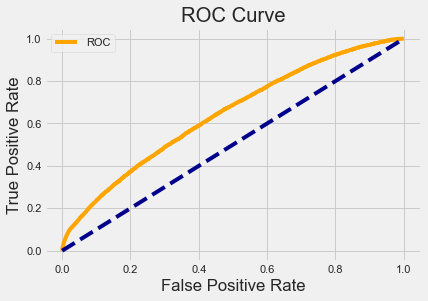

ROC value of:64.39
Accuracy:63.23
F1 score:0.70
Recall:55.81
Precision:0.35

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77   3273792
           1       0.00      0.56      0.01      7647

    accuracy                           0.63   3281439
   macro avg       0.50      0.60      0.39   3281439
weighted avg       1.00      0.63      0.77   3281439



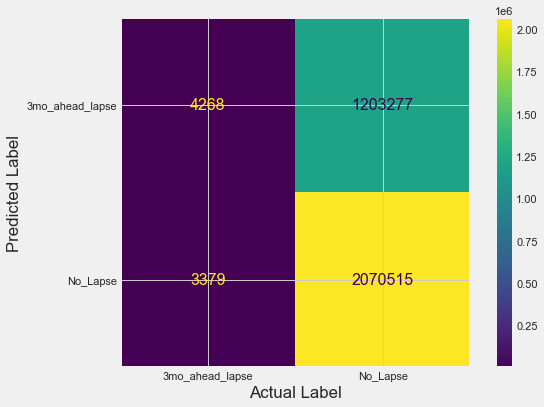

In [55]:
#### In-sample metrics
pred_Y_in = clf.predict(train_X)
pred_Y_prob_in = clf.predict_proba(train_X)[:,1]
tuned_lgb_prob_in = [train_Y, pred_Y_prob_in]
fn_metrics(train_Y, pred_Y_prob_in, pred_Y_in)

In [29]:
# # ## in-sample results 
# df_in_predict = pd.DataFrame({'prob': pred_Y_prob_in, 'predict': pred_Y_in}, columns=['prob', 'predict'], index = train_X.index.copy())

# # # Build scored dataset
# results_in = df.join(df_in_predict, how='right')

### out-of-sample fit

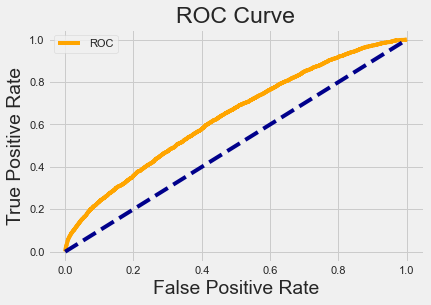

ROC value of:63.69
Accuracy:63.23
F1 score:0.70
Recall:54.51
Precision:0.35

 clasification report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.77   1091231
           1       0.00      0.55      0.01      2583

    accuracy                           0.63   1093814
   macro avg       0.50      0.59      0.39   1093814
weighted avg       1.00      0.63      0.77   1093814



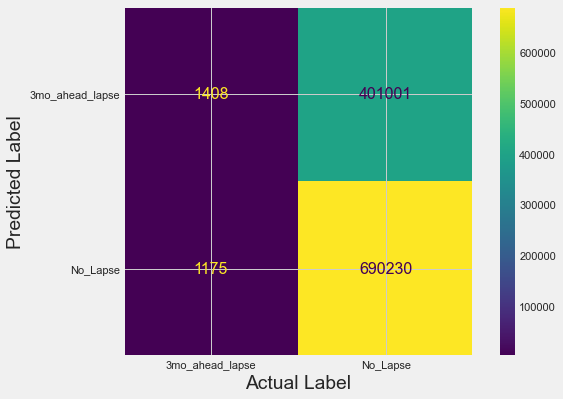

In [56]:
#Out-of-sample metrics 
pred_Y_out = clf.predict(test_X)
pred_Y_prob_out = clf.predict_proba(test_X)[:,1]
tuned_lgb_prob_out = [test_Y, pred_Y_prob_out]

#print out ROC curve, metrics, and confuction matrix
fn_metrics(test_Y, pred_Y_prob_out, pred_Y_out)

In [57]:
## out-of-sample results 
df_out_predict = pd.DataFrame({'prob': pred_Y_prob_out, 'predict': pred_Y_out}, columns=['prob', 'predict'], index = test_X.index.copy())

# Build scored dataset
score = df.join(df_out_predict, how='right')
#results_out = results_out.sort_index()

In [82]:
# sample = results_out[results_out['agmt_pkge_id']  =='R31350050000']
# sample.to_csv('sample.csv')

In [58]:
score.to_parquet('logic_out.parquet')